## Import Libraries

In [53]:
import numpy as np # package for scientific computing with Python.
import pandas as pd # library for data manipulation and analysis in Python
import matplotlib.pyplot as plt # popular library to plot graphs in Python.
import tensorflow as tf # popular platform for machine learning for building and training neural networks
import cv2 # library for computer vision applications and image processing
import os # module in Python to interact with operating system (e.g. file and directory manipulation, path manipulation, etc.)
import glob # built-in module in Python that provides a way to find files and directories based on specific patterns(*)
import random # built-in module in Python that provides functions for generating random numbers and performing random operations. 

from tensorflow import keras # Keras is a user-friendly API that sits on top od Tensorflow and simplifies the process of building and experimenting with deep learning models.
from tensorflow.keras import layers, datasets, models
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image #  library in Python that provides functionality for opening, manipulating, and saving many different image file formats.
from sklearn.model_selection import train_test_split  # basic library for data mining, used for evaluating the performance of a model.
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, f1_score, classification_report, auc #KPIs to evaluate classification models' performance

##  Define the paths to the train and test folders


In [54]:
train_folder = 'Downloads/CarLogos/Car_Brand_Logos/Train/'
test_folder = 'Downloads/CarLogos/Car_Brand_Logos/Test/'

Define the brand labels


In [55]:
brand_labels = ['volkswagen', 'toyota', 'skoda', 'opel',  'mercedes', 'mazda', 'lexus', 'hyundai']

## Load and preprocess the training data


In [58]:
# Initialize empty lists to store the preprocessed images and their corresponding labels
X_train = []
y_train = []
# Iterate over brand labels
for brand_label in brand_labels:
    folder_path = os.path.join(train_folder, brand_label) # construct the path to the folder containing images of the current brand label.
    file_paths = glob.glob(os.path.join(folder_path, '*jpg')) # find all file paths that match the pattern of '*.jpg' within the folder of the current brand label.
    for file_path in file_paths: # Iterate over each file path found in the previous step
        image = Image.open(file_path) # open the image file using the Image.open() function from the PIL
        image = image.resize((224, 224))   # Resize the image to a fixed size
        
                # Convert the image to RGB if it has only one channel
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        image = np.array(image) # covert the image to a NumPy array           
        X_train.append(image) # The preprocessed image is appended to the train images (X_train) list
        y_train.append(brand_labels.index(brand_label)) # the corresponding label is appended to the train labels (y_train) list.
                                            # The label is determined by finding the index of the current brand label in the brand_labels list.
# X_train and y_train lists are converted into NumPy arrays using np.array(), which is a common format for handling data in machine learning models.
X_train = np.array(X_train)
y_train = np.array(y_train)           
    

Check the size of images


In [59]:
print(np.min(X_train))
print(np.max(X_train))

0
255


Check the dimensions of images:
we have 2513 training examples in the training set, with height and width of 224, and three channels (colord images RGB)

In [60]:
X_train.shape

(2513, 224, 224, 3)

Normalize the pixel values to the range [0, 1] to improve the stability and convergence of the learning algorithms


In [61]:
X_train = X_train / 255.0

In [62]:
y_train.shape

(2513,)

The labels are the brand classes, from 0 to 7:


In [63]:
y_train


array([0, 0, 0, ..., 7, 7, 7])

We can plot an image using Matplotlib's imshow() function


(-0.5, 223.5, 223.5, -0.5)

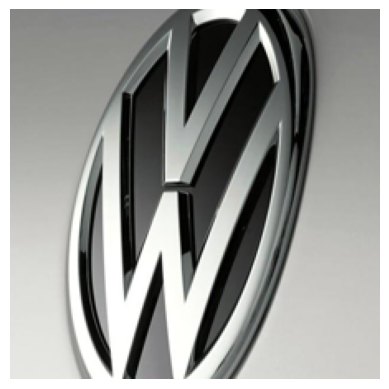

In [64]:
plt.imshow(X_train[0])
plt.axis('off')

So the first image in the training set has brand volkswagen:


In [65]:
brand_labels[y_train[0]]

'volkswagen'

## Verify the training data


Let's take a look at a random sample of the images in the dataset:


<function matplotlib.pyplot.show(close=None, block=None)>

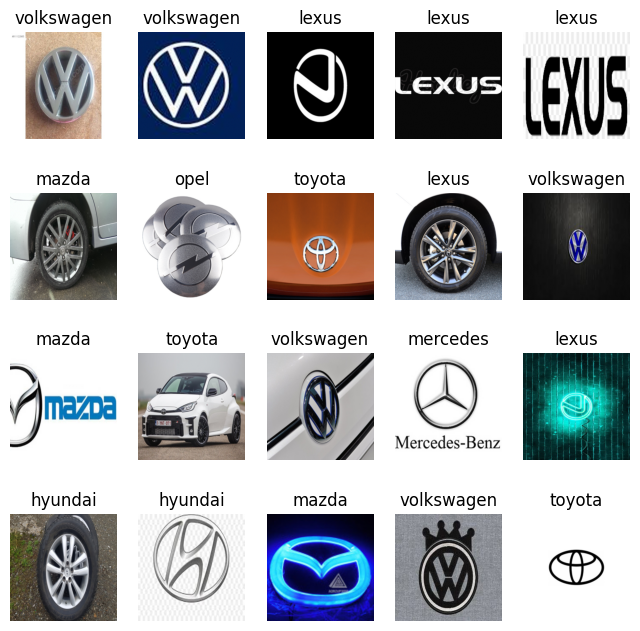

In [66]:
num_images = 20 # Number of random images to plot
random_indices = random.sample(range(len(X_train)), num_images) # select random images from the training dataset

plt.figure(figsize = (8, 8))
# Iterate over the random indices and plot the images along with their brand labels
for i, index in enumerate(random_indices):
    image = X_train[index]
    label = y_train[index]
    
    plt.subplot(4, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(brand_labels[label])
plt.show

## Load and preprocess the test data


In [67]:
# Initialize empty lists to store the preprocessed images and their corresponding labels
X_test = []
y_test = []
# Iterate over brand labels
for brand_label in brand_labels:
    folder_path = os.path.join(test_folder, brand_label) # construct the path to the folder containing images of the current brand label.
    file_paths = glob.glob(os.path.join(folder_path, '*jpg')) # find all file paths that match the pattern of '*.jpg' within the folder of the current brand label.
    for file_path in file_paths: # Iterate over each file path found in the previous step
        image = Image.open(file_path) # open the image file using the Image.open() function from the PIL
        image = image.resize((224, 224))   # Resize the image to a fixed size
        
                # Convert the image to RGB if it has only one channel
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        image = np.array(image) # covert the image to a NumPy array       
        X_test.append(image) # The preprocessed image is appended to the test images (X_test) list
        y_test.append(brand_labels.index(brand_label)) # the corresponding label is appended to the test labels (y_test) list.
                                            # The label is determined by finding the index of the current brand label in the brand_labels list.
# X_test and y_test lists are converted into NumPy arrays using np.array(), which is a common format for handling data in machine learning models.
X_test = np.array(X_test)
y_test = np.array(y_test)       

In [68]:
# Normalize the pixel values to the range [0, 1]
X_test = X_test / 255.0

In [69]:
X_test.shape

(400, 224, 224, 3)

## test train split
we split the training data into training and validation set. We use validation data to guide improvements in the model (determine if the model is underfitting or overfitting)

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [71]:
X_val.shape

(503, 224, 224, 3)

In [72]:
X_train.shape

(2010, 224, 224, 3)

## Create the convolutional base

The lines of code below define the convolutional base using a common pattern: 
The Keras Sequential model consists of convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) on top of it that is activated by a ReLU activation function ('relu').

As input, a CNN takes tensors of shape (image_height, image_width, color_channels). We can do this by passing the argument input_shape to your first layer.

In [75]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2), # 20% of the input units will be randomly set to 0 during this training step to reduce the reliance of the network on specific input features and prevent overfitting
    tf.keras.layers.Dense(8, activation='softmax')
])

### Notes:
 * Why not simply use a deep neural network with fully connected layers for image recognition tasks?  
     ** Unfortunately, although this works fine for small images (e.g., MNIST), it breaks down for larger images because of the huge number of parameters it requires. For example, a 100 × 100–pixel image has 10,000 pixels, and if the first layer has just 1,000 neurons (which already severely restricts the amount of information transmitted to the next layer), this means a total of 10 million connections. And that’s just the first layer. CNNs solve this problem using partially connected layers and weight sharing.
     ** The CNN architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on (as a hierarchical structure).  
     ** A convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.
     + All the multilayer Dense neural networks had layers composed of a long line of neurons, and we had to flatten input images to 1D before feeding them to the neural network. In a CNN each layer is represented in 2D, which makes it easier to match neurons with their corresponding inputs.
     * zero padding (padding=same) : In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs.
     * the stride: The horizontal or vertical step size from one receptive field to the next.  
     * Activation function (such as ReLU): a convolutional layer (or a Dense layer) performs a linear operation, so if you stacked multiple convolutional layers without any activation functions they would all be equivalent to a single convolutional layer, and they wouldn’t be able to learn anything really complex. 
     
     + Pooling layers: Their goal is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting).


## Compile and train the model


In [76]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, # since the target is represented as integer corresponding to the index (ather than one-hot encoded vectors), we use Sparse..
             optimizer='adam', # Adaptive Moment estimation adjusts the learning rate automatically, such that if parameters keep moving in the same direction, it increases alpha, and if they keep oscillating, reduces alpha
             metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [78]:
# The number of epochs is a hyperparameter that determines how many times the entire training dataset will be iterated over during the training process.
# Each epoch allows the model to update its weights and improve its performance based on the training examples it has seen.

history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_val, y_val))

Epoch 1/20
63/63 [==============================] - 88s 1s/step - loss: 2.1082 - accuracy: 0.1836 - val_loss: 1.9953 - val_accuracy: 0.2306
Epoch 2/20
63/63 [==============================] - 79s 1s/step - loss: 1.6723 - accuracy: 0.4184 - val_loss: 1.5795 - val_accuracy: 0.5050
Epoch 3/20
63/63 [==============================] - 81s 1s/step - loss: 1.0784 - accuracy: 0.6522 - val_loss: 1.4947 - val_accuracy: 0.5646
Epoch 4/20
63/63 [==============================] - 77s 1s/step - loss: 0.5965 - accuracy: 0.8040 - val_loss: 1.5713 - val_accuracy: 0.5984
Epoch 5/20
63/63 [==============================] - 77s 1s/step - loss: 0.3277 - accuracy: 0.9080 - val_loss: 1.9348 - val_accuracy: 0.6223
Epoch 6/20
63/63 [==============================] - 77s 1s/step - loss: 0.1588 - accuracy: 0.9557 - val_loss: 2.2207 - val_accuracy: 0.6342
Epoch 7/20
63/63 [==============================] - 79s 1s/step - loss: 0.1641 - accuracy: 0.9537 - val_loss: 2.1950 - val_accuracy: 0.6004
Epoch 8/20
63/63 [==

## Visualize training results


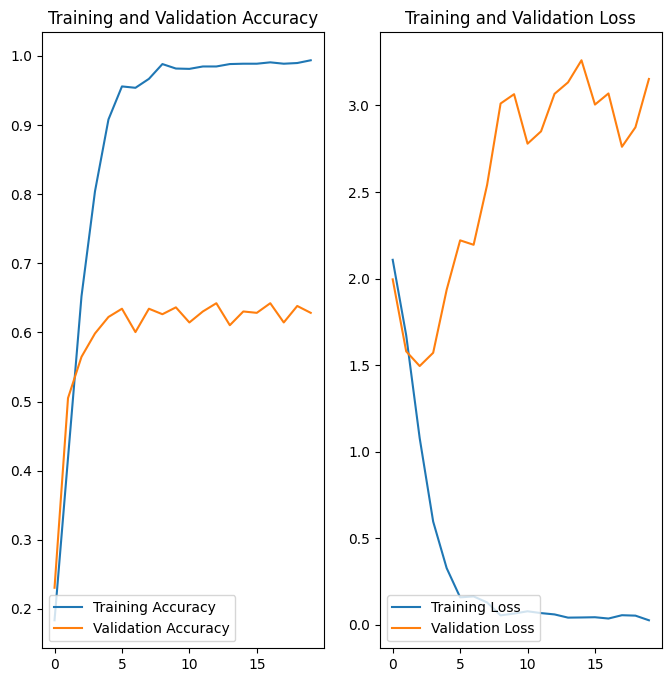

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2 ,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training Loss")
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy and loss (cost) between training and validation is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. Below, I'll use data augmentation (dropout was already added to my model.)

Model Complexity is another aspect which should be considered. A complex model (with too many layers and units in each layer) may be more likely to overfit. We can either try a simpler moder and compare it with a more complex model or use regularization to moderate the impact of a more complex model:  
 * we can try increasing the dropout rate or adding additional dropout layers between the dense layers;  
 * we can also Increase the strength of regularization techniques such as L1 or L2 regularization by adding corresponding regularization terms to the loss function. W can also iterate to find optimal regularization value using kernel_regularizer=tf.keras.regularizers.l2(lambda_) inside our Dense layers where range of lamdas to try on can be for instance: lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3])

In [86]:
model = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape = (224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(8)
]
)

## Compile and train the model

In [87]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)     

In [89]:
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_val, y_val))

Epoch 1/20
63/63 [==============================] - 108s 2s/step - loss: 2.1623 - accuracy: 0.1458 - val_loss: 2.0570 - val_accuracy: 0.2127
Epoch 2/20
63/63 [==============================] - 92s 1s/step - loss: 2.0111 - accuracy: 0.2338 - val_loss: 1.9709 - val_accuracy: 0.2366
Epoch 3/20
63/63 [==============================] - 81s 1s/step - loss: 1.8162 - accuracy: 0.3458 - val_loss: 1.7451 - val_accuracy: 0.4135
Epoch 4/20
63/63 [==============================] - 88s 1s/step - loss: 1.6345 - accuracy: 0.4428 - val_loss: 1.5635 - val_accuracy: 0.4632
Epoch 5/20
63/63 [==============================] - 84s 1s/step - loss: 1.4820 - accuracy: 0.4751 - val_loss: 1.5377 - val_accuracy: 0.4791
Epoch 6/20
63/63 [==============================] - 79s 1s/step - loss: 1.3941 - accuracy: 0.5164 - val_loss: 1.4939 - val_accuracy: 0.4891
Epoch 7/20
63/63 [==============================] - 81s 1s/step - loss: 1.3217 - accuracy: 0.5398 - val_loss: 1.4459 - val_accuracy: 0.5209
Epoch 8/20
63/63 [=

## Visualize training results

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

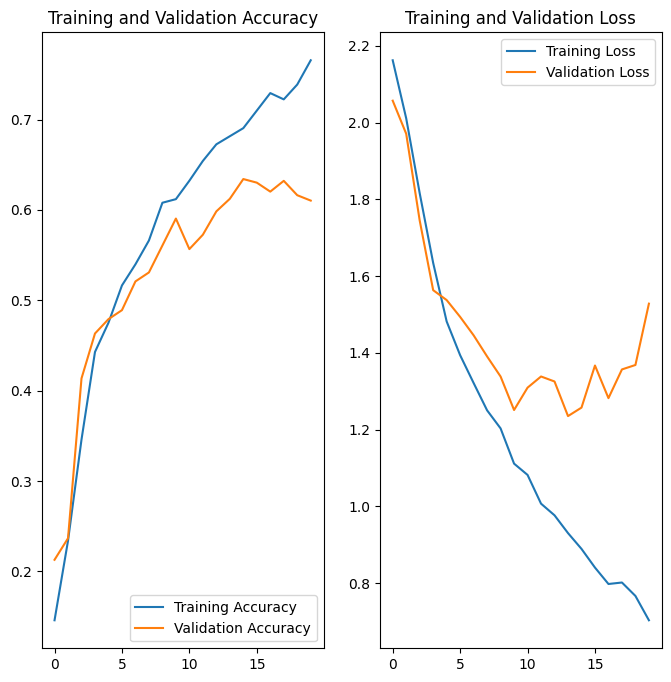

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluating the model


In [93]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 4s 257ms/step - loss: 1.8147 - accuracy: 0.5750


[1.8146814107894897, 0.574999988079071]

## Predict on test data

1/1 [==============================] - 1s 535ms/step


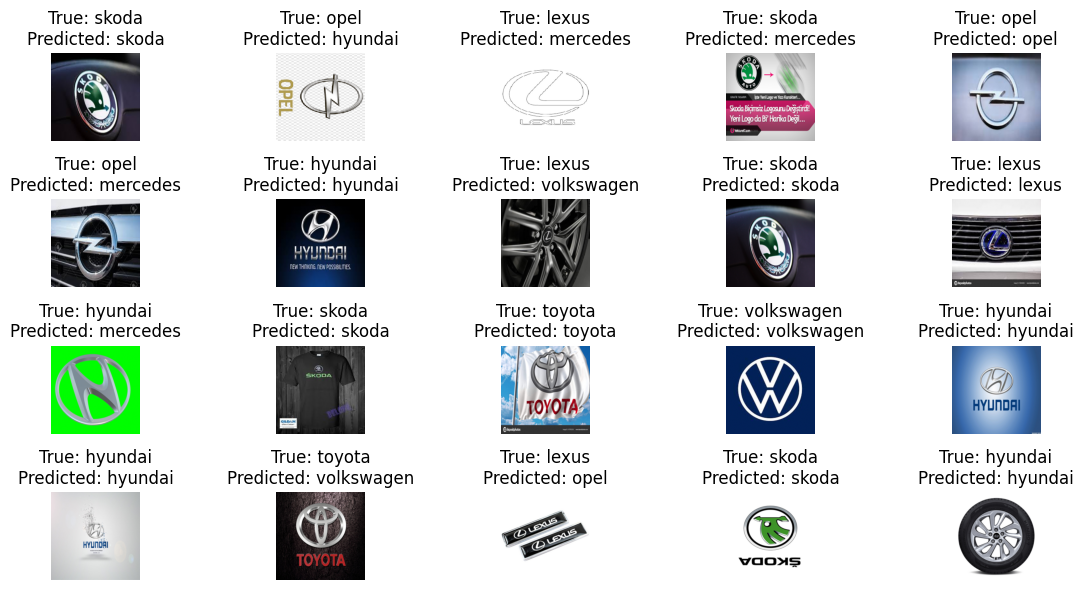

In [94]:
num_images = 20  # Number of random images to plot
random_indices = random.sample(range(len(X_test)), num_images) # Generates a list of num_images random indices from the test_images list.

# Predicting a probability vector
predictions = model.predict(X_test[random_indices]) # Uses the trained model to predict the labels for the randomly selected images by passing them to the model.predict() method.
y_pred = np.argmax(predictions, axis=-1) # Computes the predicted labels by finding the index with the highest probability for each prediction using np.argmax()

plt.figure(figsize=(12, 6))
for i, index in enumerate(random_indices): # Iterates over the random indices and their corresponding iteration number i.
    image = X_test[index] # retrieves the image corresponding to the current index.
    true_label = brand_labels[y_test[index]] #Retrieves the true label of the current image from the test_labels using index and maps it to the corresponding color label using the color_labels list.
    predicted_label = brand_labels[y_pred[i]]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
plt.tight_layout()
plt.show()
